In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('NYC_Taxi_dataset.csv')
df.head(2)

pickup_datetime     dropoff_datetime  pickup_latitude  \
0  2023-02-20 17:27:00  2023-02-20 17:49:00        40.808941   
1  2023-02-28 19:41:00  2023-02-28 20:07:00        40.685842   

   pickup_longitude  dropoff_latitude  dropoff_longitude  trip_distance_miles  \
0        -73.914482         40.807336         -73.905270                 1.03   
1        -73.855449         40.663358         -73.826745                 4.02   

   fare_amount  passenger_count payment_type  
0         5.84                5  Credit Card  
1        20.88                4      Unknown

# Skimming Data

In [5]:
pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'null_value(%)': df.isna().mean().values * 100,
    'neg_value(%)': [len(df[col][df[col] < 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],
    '0_value(%)': [len(df[col][df[col] == 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],
    'duplicate' : df.duplicated().sum(),
    'n_unique': df.nunique().values,
    'sample_unique': [df[col].unique() for col in df.columns]}
).round(3)

feature data_type  null_value(%)  neg_value(%)  0_value(%)  \
0      pickup_datetime    object            0.0           0.0         0.0   
1     dropoff_datetime    object            0.0           0.0         0.0   
2      pickup_latitude   float64            0.0           0.0         0.0   
3     pickup_longitude   float64            0.0         100.0         0.0   
4     dropoff_latitude   float64            0.0           0.0         0.0   
5    dropoff_longitude   float64            0.0         100.0         0.0   
6  trip_distance_miles   float64            0.0           0.0         0.0   
7          fare_amount   float64            0.0           0.0         0.0   
8      passenger_count     int64            0.0           0.0         0.0   
9         payment_type    object            0.0           0.0         0.0   

   duplicate  n_unique                                      sample_unique  
0          0       798  [2023-02-20 17:27:00, 2023-02-28 19:41:00, 202...  
1          0       797  [2023-02-20 17:49:00, 2023-02-28 20:07:00, 202...  
2          0       800  [40.808941, 40.685842, 40.668055, 40.765394, 4...  
3          0       799  [-73.914482, -73.855449, -74.04505, -73.753324...  
4          0       799  [40.807336, 40.663358, 40.642572, 40.775285, 4...  
5          0       799  [-73.90527, -73.826745, -74.055617, -73.775441...  
6          0       335  [1.03, 4.02, 3.04, 2.67, 3.11, 4.18, 2.27, 4.0...  
7          0       612  [5.84, 20.88, 14.14, 11.04, 16.12, 13.5, 10.6,...  
8          0         5                                    [5, 4, 3, 2, 1]  
9          0         5   [Credit Card, Unknown, Cash, Dispute, No Charge]

In [6]:
df.shape

(800, 10)

**Scénario 1 : Taxi Driver**



1.   les attributs critiques

Pour le taxi driver les colonnes qui suivent sont important : **fare_amount**, **trip_distance_miles**, **pickup_datetime**, **dropoff_datetime**, **pickup_latitude**, **pickup_longitude**.

2.   les dimensions importants : On pourra citer la **completness**, l'**accuracy**, la **consistancy**

  La **completness** dans le sens ou sur les colonnes fare_amount l'absence de valeur impacterait sa comptabilité, trip_distance_miles pour vérifier la cohérence avec le prix, pickup_datetime et dropoff_datetime pour la durée du trajet.
  
  
 L'accuracy est aussi important sur les colonnes **fare_amount** pour une comptabilité fiable, et **trip_distance_miles**.

 La **consistancy** sur les colonnes  **pickup_datetime** < **dropoff_datetime** et **pickup_latitude** < **pickup_longitude** pour toujours garder une cohérence dans les données, **fare_amount** > 0, **trip_distance_miles** > 0,







**Scénario 2 : Passenger**


1.   Attributs critiques
    
     Les colonnes qui suivent sont important du point de vue passager : **fare_amount**, **passenger_count**, **pickup_datetime**, **dropoff_datetime**

2.   Dimensions importants: **consistancy** sur le tuple d'attribut (**pickup_datetime** < **dropoff_datetime**), **completeness** et **accuracy** sur **fare_amount**







### Data profiling

In [7]:
df.dtypes

pickup_datetime         object
dropoff_datetime        object
pickup_latitude        float64
pickup_longitude       float64
dropoff_latitude       float64
dropoff_longitude      float64
trip_distance_miles    float64
fare_amount            float64
passenger_count          int64
payment_type            object
dtype: object

In [10]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report")

In [12]:
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Render HTML: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


On constate à travers le profiling:
- une completness total sur nos attributs
- une absence de lignes identiques
- toutes les colonnes de dates sont valides
- La colonne passenger_count a des valeurs toutes comprises [1,5] ce qui est correct
- 


In [20]:
# --- 1) Doublons ---
print("--- Doublons ---")
total_dup = df.duplicated().sum()
print(f"Doublons totaux (lignes identiques) : {total_dup}")

--- Doublons ---
Doublons totaux (lignes identiques) : 0


In [21]:
# Doublons selon un sous-ensemble métier
subset_cols = ["pickup_datetime","dropoff_datetime","fare_amount","pickup_latitude","pickup_longitude"]
subset_dup = df.duplicated(subset=subset_cols).sum()
print(f"Doublons sur le subset {subset_cols} : {subset_dup}")
if subset_dup > 0:
    display(df[df.duplicated(subset=subset_cols, keep=False)].head(10))

Doublons sur le subset ['pickup_datetime', 'dropoff_datetime', 'fare_amount', 'pickup_latitude', 'pickup_longitude'] : 0


# Etape 3 : Data Quality Assessment

### Dimensions du scenario driver

In [8]:
driver_scenario_df = df[["fare_amount", "trip_distance_miles", "pickup_datetime", "dropoff_datetime", "pickup_latitude", "pickup_longitude"]]

### Completness

On constate à travers le profiling une completness total sur nos attributs

In [ ]:
# === Complétude (%) et Accuracy — Scénario Driver ===
# Colonnes critiques
cols = ["fare_amount", "trip_distance_miles", "pickup_datetime", "dropoff_datetime", "pickup_latitude", "pickup_longitude"]

# Copie locale
dq = driver_scenario_df[cols].copy()

# 1) Complétude (%) par colonne
compl_pct = (dq.notna().mean() * 100).round(2)
compl_df = compl_pct.reset_index()
compl_df.columns = ["feature", "completeness_percent"]
print("--- Complétude (%) ---")
display(compl_df)

# 2) Accuracy (checks métiers simples)
print('\n--- Accuracy checks ---')
checks = {}

# fare_amount: > 0 et outliers via IQR
if 'fare_amount' in dq.columns:
    s = dq['fare_amount']
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = max(0, q1 - 1.5 * iqr), q3 + 1.5 * iqr
    checks['fare_amount'] = {
        'n_null': int(s.isna().sum()),
        'pct_null': float(s.isna().mean() * 100),
        'n_nonpositive': int((s <= 0).sum()),
        'pct_nonpositive': float((s <= 0).mean() * 100),
        'iqr_lower': float(lower),
        'iqr_upper': float(upper),
        'n_outliers_iqr': int(((s < lower) | (s > upper)).sum())
    }

# trip_distance_miles: >=0 et outliers
if 'trip_distance_miles' in dq.columns:
    s = dq['trip_distance_miles']
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = max(0, q1 - 1.5 * iqr), q3 + 1.5 * iqr
    checks['trip_distance_miles'] = {
        'n_null': int(s.isna().sum()),
        'pct_null': float(s.isna().mean() * 100),
        'n_negative': int((s < 0).sum()),
        'pct_negative': float((s < 0).mean() * 100),
        'iqr_lower': float(lower),
        'iqr_upper': float(upper),
        'n_outliers_iqr': int(((s < lower) | (s > upper)).sum())
    }

# Datetime validity & order
for col in ['pickup_datetime', 'dropoff_datetime']:
    if col in dq.columns:
        s = pd.to_datetime(dq[col], errors='coerce')
        checks[col] = {'n_invalid': int(s.isna().sum()), 'pct_invalid': float(s.isna().mean() * 100)}

if ('pickup_datetime' in dq.columns) and ('dropoff_datetime' in dq.columns):
    pu = pd.to_datetime(dq['pickup_datetime'], errors='coerce')
    do = pd.to_datetime(dq['dropoff_datetime'], errors='coerce')
    bad_order = ((pu.notna()) & (do.notna()) & (pu >= do)).sum()
    checks['pickup_before_dropoff'] = {'n_bad_order': int(bad_order), 'pct_bad_order': float(bad_order / len(dq) * 100)}

# Pickup lat/lon in NYC bounds
nyc_min_latitude = 40.5
nyc_max_latitude = 40.9
nyc_min_longitude = -74.25
nyc_max_longitude = -73.7
if ('pickup_latitude' in dq.columns) and ('pickup_longitude' in dq.columns):
    lat = dq['pickup_latitude']
    lon = dq['pickup_longitude']
    in_nyc = ((lat >= nyc_min_latitude) & (lat <= nyc_max_latitude) & (lon >= nyc_min_longitude) & (lon <= nyc_max_longitude)).mean() * 100
    checks['pickup_latlon'] = {'pct_in_nyc': float(in_nyc), 'n_null_lat': int(lat.isna().sum()), 'n_null_lon': int(lon.isna().sum())}

# Affichage du résumé
print('\n--- Résumé des checks ---')
summary = pd.DataFrame.from_dict(checks, orient='index')
summary = summary.fillna('').reset_index().rename(columns={'index':'check'})
display(summary)

# Exemples d'enregistrements problématiques (max 5)
print('\n--- Exemples (max 5) ---')
# fare problematic
if 'fare_amount' in dq.columns:
    bad_fare = dq[(dq['fare_amount'] <= 0) | (dq['fare_amount'] > checks['fare_amount']['iqr_upper'])]
    if len(bad_fare):
        print('Exemples fare_amount non-positif ou hors IQR:')
        display(bad_fare[['fare_amount','trip_distance_miles','pickup_datetime']].head(5))
# distance problematic
if 'trip_distance_miles' in dq.columns:
    bad_dist = dq[(dq['trip_distance_miles'] < 0) | (dq['trip_distance_miles'] > checks['trip_distance_miles']['iqr_upper'])]
    if len(bad_dist):
        print('Exemples trip_distance_miles invalides:')
        display(bad_dist[['trip_distance_miles','fare_amount','pickup_datetime']].head(5))
# datetime invalids and bad order
bad_pu = dq[pd.to_datetime(dq['pickup_datetime'], errors='coerce').isna()]
bad_do = dq[pd.to_datetime(dq['dropoff_datetime'], errors='coerce').isna()]
if len(bad_pu):
    print('Exemples pickup_datetime invalid:')
    display(bad_pu[['pickup_datetime','dropoff_datetime','fare_amount']].head(5))
if len(bad_do):
    print('Exemples dropoff_datetime invalid:')
    display(bad_do[['pickup_datetime','dropoff_datetime','fare_amount']].head(5))
# pickup >= dropoff
bad_order_df = dq[(pd.to_datetime(dq['pickup_datetime'], errors='coerce').notna()) & (pd.to_datetime(dq['dropoff_datetime'], errors='coerce').notna()) & (pd.to_datetime(dq['pickup_datetime'], errors='coerce') >= pd.to_datetime(dq['dropoff_datetime'], errors='coerce'))]
if len(bad_order_df):
    print('Exemples pickup >= dropoff:')
    display(bad_order_df[['pickup_datetime','dropoff_datetime','fare_amount']].head(5))
# pickup hors NYC
if ('pickup_latitude' in dq.columns) and ('pickup_longitude' in dq.columns):
    outside = dq[~((dq['pickup_latitude'] >= nyc_min_latitude) & (dq['pickup_latitude'] <= nyc_max_latitude) & (dq['pickup_longitude'] >= nyc_min_longitude) & (dq['pickup_longitude'] <= nyc_max_longitude))]
    if len(outside):
        print('Exemples pickup hors NYC:')
        display(outside[['pickup_latitude','pickup_longitude','pickup_datetime']].head(5))

print('\nTerminé. Ajustez les seuils/IQR si vous souhaitez une définition d\'outlier différente.')

### Accuracy

In [10]:
print(f"dataframe describe \n: {driver_scenario_df.describe()}")

dataframe describe 
:        fare_amount  trip_distance_miles  pickup_latitude  pickup_longitude
count   800.000000           800.000000       800.000000        800.000000
mean     12.636225             2.558612        40.751655        -73.878843
std       3.352882             0.931247         0.085945          0.104064
min       3.150000             0.040000        40.600025        -74.049958
25%      10.197500             1.900000        40.679936        -73.972376
50%      12.690000             2.650000        40.750586        -73.880704
75%      15.037500             3.250000        40.825291        -73.791455
max      21.890000             4.540000        40.899676        -73.700125


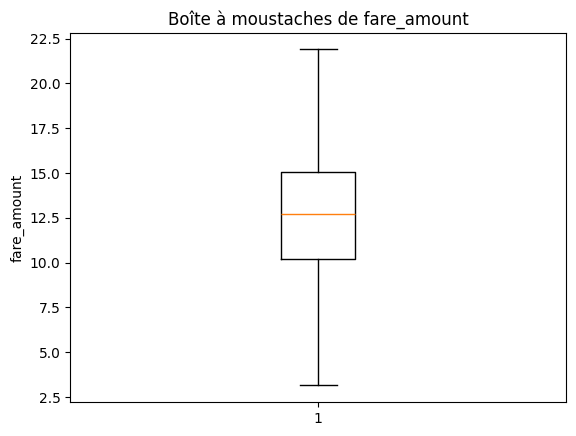

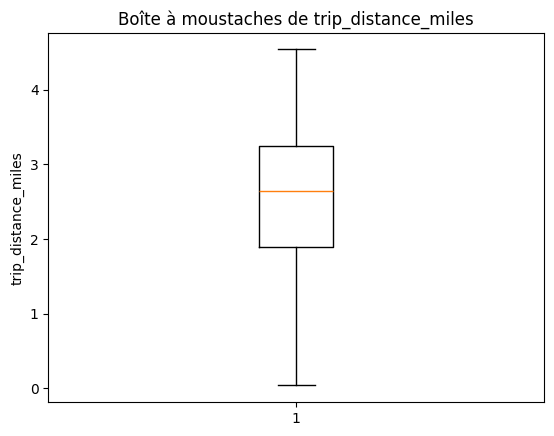

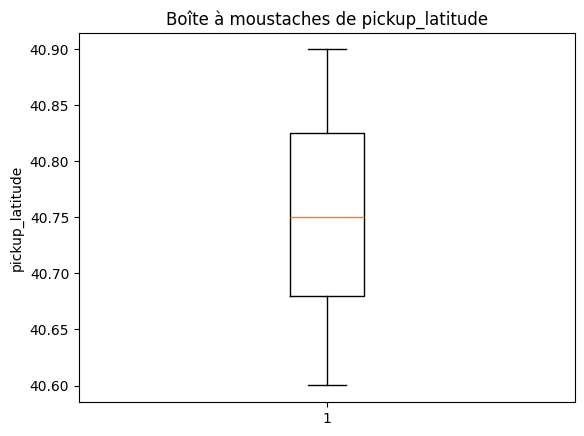

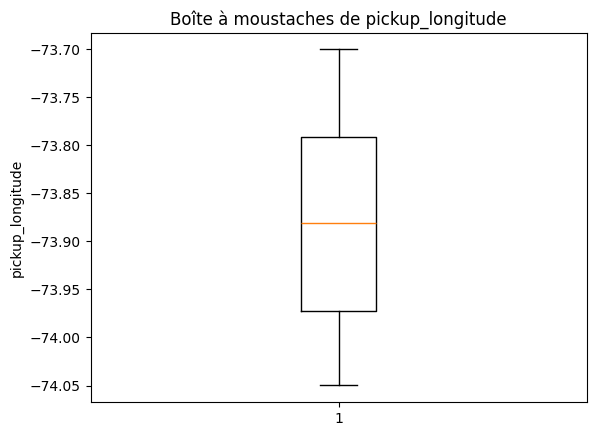

In [11]:
import matplotlib.pyplot as plt

colonnes = [
    "fare_amount",
    "trip_distance_miles",
    "pickup_latitude",
    "pickup_longitude"
]

for col in colonnes:
    plt.figure()
    plt.boxplot(driver_scenario_df[col].dropna())
    plt.title(f"Boîte à moustaches de {col}")
    plt.ylabel(col)
    plt.show()


L'observation des boites à moustache nous permet de dire qu'on a pas de valeur aberrante selon la méthode des quartiles

In [12]:
#parsing des colonnes de type date
driver_scenario_df["pickup_datetime"] = pd.to_datetime(driver_scenario_df["pickup_datetime"],errors='coerce')
driver_scenario_df["dropoff_datetime"] = pd.to_datetime(driver_scenario_df["dropoff_datetime"],errors='coerce')

driver_scenario_df.dtypes

/tmp/ipython-input-40902778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_scenario_df["pickup_datetime"] = pd.to_datetime(driver_scenario_df["pickup_datetime"],errors='coerce')
/tmp/ipython-input-40902778.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_scenario_df["dropoff_datetime"] = pd.to_datetime(driver_scenario_df["dropoff_datetime"],errors='coerce')


fare_amount                   float64
trip_distance_miles           float64
pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
pickup_latitude               float64
pickup_longitude              float64
dtype: object

In [13]:
driver_scenario_df[['pickup_datetime','dropoff_datetime']].isna().sum()


pickup_datetime     0
dropoff_datetime    0
dtype: int64

On a toutes les dates qui sont valides, on pourra ainsi conclure sur les colonnes de pickup/dropoff_datetime un degre d'accuracy de 100%

In [14]:
# Approximation coordonnées ville de new York
nyc_min_latitude = 40.5
nyc_max_latitude = 40.9
nyc_min_longitude = -74.25
nyc_max_longitude = -73.7

# On verifie si les valeur pickup sont dans NYC
driver_scenario_df['is_pickup_in_nyc'] = (
    (driver_scenario_df['pickup_latitude'] >= nyc_min_latitude) &
    (driver_scenario_df['pickup_latitude'] <= nyc_max_latitude) &
    (driver_scenario_df['pickup_longitude'] >= nyc_min_longitude) &
    (driver_scenario_df['pickup_longitude'] <= nyc_max_longitude)
)

# Pourcentage coordonnées valides
percentage_in_nyc = driver_scenario_df['is_pickup_in_nyc'].mean() * 100



/tmp/ipython-input-3101680750.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_scenario_df['is_pickup_in_nyc'] = (


In [15]:
print(f"Accuracy attribut pickup_latitude: {percentage_in_nyc:.2f}%")


Accuracy attribut pickup_latitude: 100.00%


### Consistancy

In [16]:
# Valeur négative
driver_scenario_df[["fare_amount","trip_distance_miles"]].describe()



fare_amount  trip_distance_miles
count   800.000000           800.000000
mean     12.636225             2.558612
std       3.352882             0.931247
min       3.150000             0.040000
25%      10.197500             1.900000
50%      12.690000             2.650000
75%      15.037500             3.250000
max      21.890000             4.540000

On constate qu'on a pas de valeur négative dans dans les colonnes fare_amounnt et trip_distance_miles

In [17]:
# 1. Cohérence des valeurs positives
# (D'après les observations précédentes, min > 0 pour les deux, donc 100% de cohérence sur ce point)
consistency_positive_values = (
    (driver_scenario_df['fare_amount'] > 0) &
    (driver_scenario_df['trip_distance_miles'] > 0)
).mean() * 100

# 2. Cohérence : Pas de distance nulle avec un prix non nul
# On vérifie les cas où (distance == 0 ET prix > 0) sont faux
consistency_zero_distance_fare = (
    ~((driver_scenario_df['trip_distance_miles'] == 0) & (driver_scenario_df['fare_amount'] > 0))
).mean() * 100

print(f"1. Pourcentage de valeurs positives (fare_amount & trip_distance_miles): {consistency_positive_values:.2f}%")
print(f"2. Pourcentage de non-occurrence '0 distance avec prix non nul': {consistency_zero_distance_fare:.2f}%")


1. Pourcentage de valeurs positives (fare_amount & trip_distance_miles): 100.00%
2. Pourcentage de non-occurrence '0 distance avec prix non nul': 100.00%


Le resultat dessus confirme l'observation qu'on avait sur la description du jeu de données

In [18]:

#  Analyser le  tarif par mile (1,61 kilomètres)
#  Calcul du tarif par mile
driver_scenario_df['fare_per_mile'] = driver_scenario_df.apply(
    lambda row: row['fare_amount'] / row['trip_distance_miles'] if row['trip_distance_miles'] > 0 else 0,
    axis=1
)

print(driver_scenario_df['fare_per_mile'].describe())


count    800.000000
mean       5.749083
std        5.906589
min        3.043584
25%        4.251232
50%        4.967206
75%        5.775745
max      131.000000
Name: fare_per_mile, dtype: float64


/tmp/ipython-input-1228194202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_scenario_df['fare_per_mile'] = driver_scenario_df.apply(


In [19]:
print("Top 5 des courses avec le 'fare_per_mile' le plus élevé:")
display(driver_scenario_df.nlargest(5, 'fare_per_mile'))

Top 5 des courses avec le 'fare_per_mile' le plus élevé:


fare_amount  trip_distance_miles     pickup_datetime    dropoff_datetime  \
138         5.24                 0.04 2023-01-18 02:19:00 2023-01-18 02:31:00   
443         6.85                 0.08 2023-02-01 10:43:00 2023-02-01 11:02:00   
427         8.02                 0.16 2023-02-21 11:02:00 2023-02-21 11:45:00   
728         8.27                 0.33 2023-02-15 19:28:00 2023-02-15 19:42:00   
553         9.02                 0.41 2023-01-23 23:18:00 2023-01-23 23:44:00   

     pickup_latitude  pickup_longitude  is_pickup_in_nyc  fare_per_mile  
138        40.735191        -74.044806              True     131.000000  
443        40.684143        -73.868030              True      85.625000  
427        40.722598        -73.786425              True      50.125000  
728        40.683606        -73.739927              True      25.060606  
553        40.827084        -73.780996              True      22.000000

Nous detectons ici clairement la présence de **valeurs** **aberrantes**

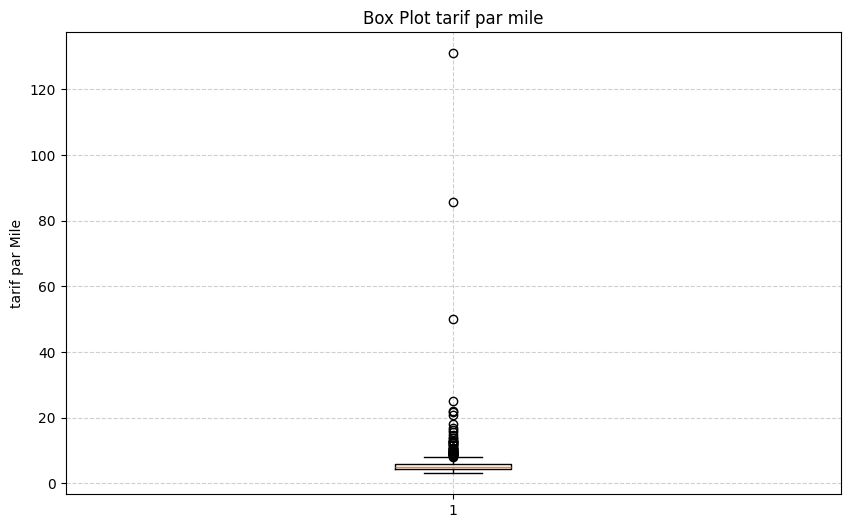

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.boxplot(driver_scenario_df['fare_per_mile'][driver_scenario_df['fare_per_mile'] > 0].dropna())
plt.title("Box Plot tarif par mile")
plt.ylabel("tarif par Mile")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

La lecture de cette boite à moustache de la var **fare_per_mile** (variable obtenu par le rapport des var **fare_amount** et **trip_distance_miles**) nous confirme la présence d'aberration sur le couple de variable ( **fare_amount**, **trip_distance_miles**)

L'interpretation de la boite nous donne un prix median autour de 5. La fixation de valeurs seuils (min et max) reste plus ou moins subjectif mais pourrait servir à ici à determiner la consistence des données dans ces 2 colonnes.

In [21]:


# 3. Cohérence du tarif par mile : identification des outliers via IQR
Q1 = driver_scenario_df['fare_per_mile'].quantile(0.25)
Q3 = driver_scenario_df['fare_per_mile'].quantile(0.75)
IQR = Q3 - Q1

# Définir des bornes pour les outliers (1.5 * IQR est une méthode courante)
lower_bound_fare_per_mile = Q1 - 1.5 * IQR
upper_bound_fare_per_mile = Q3 + 1.5 * IQR

# Assurer que la borne inférieure n'est pas négative, car le tarif par mile doit être positif
lower_bound_fare_per_mile = max(0, lower_bound_fare_per_mile)

# Calculer le pourcentage de 'fare_per_mile' dans la fourchette raisonnable
consistency_fare_per_mile_in_range = (
    (driver_scenario_df['fare_per_mile'] >= lower_bound_fare_per_mile) &
    (driver_scenario_df['fare_per_mile'] <= upper_bound_fare_per_mile)
).mean() * 100


print(f"\n--- Seuils définis pour 'fare_per_mile' (méthode IQR) ---")
print(f"Q1 (25e percentile): {Q1:.2f}")
print(f"Q3 (75e percentile): {Q3:.2f}")
print(f"IQR (Interquartile Range): {IQR:.2f}")
print(f"Borne inférieure du 'fare_per_mile' (excluant les outliers): {lower_bound_fare_per_mile:.2f}")
print(f"Borne supérieure du 'fare_per_mile' (excluant les outliers): {upper_bound_fare_per_mile:.2f}")
print(f"3. Pourcentage de 'fare_per_mile' dans la fourchette des valeurs consistantes: {consistency_fare_per_mile_in_range:.2f}%")


--- Seuils définis pour 'fare_per_mile' (méthode IQR) ---
Q1 (25e percentile): 4.25
Q3 (75e percentile): 5.78
IQR (Interquartile Range): 1.52
Borne inférieure du 'fare_per_mile' (excluant les outliers): 1.96
Borne supérieure du 'fare_per_mile' (excluant les outliers): 8.06
3. Pourcentage de 'fare_per_mile' dans la fourchette des valeurs consistantes: 93.62%


Par observation des valeurs numériques on pourrait penser avoir des valeurs consistantes.

1.   Élément de liste
2.   Élément de liste



In [22]:

driver_relevance_conditions = (
    driver_scenario_df['fare_amount'].notna() &
    driver_scenario_df['trip_distance_miles'].notna() &
    driver_scenario_df['pickup_datetime'].notna() &
    driver_scenario_df['dropoff_datetime'].notna() &
    driver_scenario_df['pickup_latitude'].notna() &
    driver_scenario_df['pickup_longitude'].notna() &
    (driver_scenario_df['fare_amount'] > 0) &
    (driver_scenario_df['trip_distance_miles'] > 0) &
    (driver_scenario_df['pickup_datetime'] < driver_scenario_df['dropoff_datetime']) &
    (driver_scenario_df['is_pickup_in_nyc'] == True)
)

driver_scenario_df['is_relevant_driver'] = driver_relevance_conditions.astype(int)
driver_relevance_score = driver_scenario_df['is_relevant_driver'].mean() * 100
print(f"Relevance (Driver) : {driver_relevance_score:.2f}% de trajets pertinents pour le scénario Driver")


Relevance (Driver) : 100.00% de trajets pertinents pour le scénario Driver


/tmp/ipython-input-1855651668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_scenario_df['is_relevant_driver'] = driver_relevance_conditions.astype(int)


In [23]:
# Scénario Passenger
passenger_scenario_df = df[["fare_amount", "passenger_count", "pickup_datetime", "dropoff_datetime"]].copy()

# parsing dates si pas déjà fait sur df
passenger_scenario_df["pickup_datetime"] = pd.to_datetime(passenger_scenario_df["pickup_datetime"], errors='coerce')
passenger_scenario_df["dropoff_datetime"] = pd.to_datetime(passenger_scenario_df["dropoff_datetime"], errors='coerce')

In [24]:
passenger_relevance_conditions = (
    passenger_scenario_df['fare_amount'].notna() &
    passenger_scenario_df['pickup_datetime'].notna() &
    passenger_scenario_df['dropoff_datetime'].notna() &
    (passenger_scenario_df['fare_amount'] > 0) &
    (passenger_scenario_df['pickup_datetime'] < passenger_scenario_df['dropoff_datetime'])
)

passenger_scenario_df['is_relevant_passenger'] = passenger_relevance_conditions.astype(int)
passenger_relevance_score = passenger_scenario_df['is_relevant_passenger'].mean() * 100
print(f"Relevance (Passenger) : {passenger_relevance_score:.2f}% de trajets pertinents pour le scénario Passenger")


Relevance (Passenger) : 100.00% de trajets pertinents pour le scénario Passenger
